# Определение стоимости автомобилей

Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В вашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Вам нужно построить модель для определения стоимости. 

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

In [1]:
pip install phik -q

Note: you may need to restart the kernel to use updated packages.


In [2]:
!pip install scikit-learn==1.1.3 -q

In [3]:
pip install lightgbm -q

Note: you may need to restart the kernel to use updated packages.


In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

import seaborn as sns
from phik.report import plot_correlation_matrix
from phik import phik_matrix

from sklearn.model_selection import train_test_split

from sklearn.pipeline import Pipeline

from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler, MinMaxScaler, RobustScaler
from sklearn.compose import ColumnTransformer

from sklearn.impute import SimpleImputer

from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC

from sklearn.linear_model import LinearRegression, SGDRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR, LinearSVR

from sklearn.metrics import roc_auc_score
from sklearn.metrics import mean_squared_error

from sklearn.model_selection import StratifiedKFold

import lightgbm as lgb

In [5]:
RANDOM_STATE = 12345
TEST_SIZE = 0.25

## Подготовка данных

In [6]:
# загрузка данных
autos = pd.read_csv('autos.csv')

In [7]:
autos.head()

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


Данные совпадают с описанием из задачи. Приведем наименование столбцов к виду, соответствующему общепринятому.

In [8]:
autos.columns = ['date_crawled', 'price', 'vehicle_type', 'registration_year', 'gearbox', 'power',
                 'model', 'kilometer', 'registration_month', 'fuel_type', 'brand', 'repaired',
                 'date_created', 'number_of_pictures', 'postal_code', 'last_seen']
autos.head()

,date_crawled,price,vehicle_type,registration_year,gearbox,power,model,kilometer,registration_month,fuel_type,brand,repaired,date_created,number_of_pictures,postal_code,last_seen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


Наименования столбцов изменены. Теперь рассмотрим общую информацию о датафрейме.

In [9]:
autos.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column              Non-Null Count   Dtype 
---  ------              --------------   ----- 
 0   date_crawled        354369 non-null  object
 1   price               354369 non-null  int64 
 2   vehicle_type        316879 non-null  object
 3   registration_year   354369 non-null  int64 
 4   gearbox             334536 non-null  object
 5   power               354369 non-null  int64 
 6   model               334664 non-null  object
 7   kilometer           354369 non-null  int64 
 8   registration_month  354369 non-null  int64 
 9   fuel_type           321474 non-null  object
 10  brand               354369 non-null  object
 11  repaired            283215 non-null  object
 12  date_created        354369 non-null  object
 13  number_of_pictures  354369 non-null  int64 
 14  postal_code         354369 non-null  int64 
 15  last_seen           354369 non-null  object
dtypes:

В датафрейме 354 369 строк. Видим, что в столбцах ```vehicle_type, gearbox, model, fuel_type, repaired``` есть пропущенные значения. Также для столбцов, которые представляют даты ```date_crawled, date_created, last_seen``` тип значений ```object```, а не ```datetime```. Изменим типы для этих столбцов.

In [10]:
autos['date_crawled'] = pd.to_datetime(autos['date_crawled'], format='%Y-%m-%d %H:%M:%S')
autos['date_created'] = pd.to_datetime(autos['date_created'], format='%Y-%m-%d %H:%M:%S')
autos['last_seen'] = pd.to_datetime(autos['last_seen'], format='%Y-%m-%d %H:%M:%S')

In [11]:
autos.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column              Non-Null Count   Dtype         
---  ------              --------------   -----         
 0   date_crawled        354369 non-null  datetime64[ns]
 1   price               354369 non-null  int64         
 2   vehicle_type        316879 non-null  object        
 3   registration_year   354369 non-null  int64         
 4   gearbox             334536 non-null  object        
 5   power               354369 non-null  int64         
 6   model               334664 non-null  object        
 7   kilometer           354369 non-null  int64         
 8   registration_month  354369 non-null  int64         
 9   fuel_type           321474 non-null  object        
 10  brand               354369 non-null  object        
 11  repaired            283215 non-null  object        
 12  date_created        354369 non-null  datetime64[ns]
 13  number_of_pictures  354369 no

Типы данных для столбцов с датами изменены на ```datetime```.

Рассмотрим значения в столбцах.

In [12]:
autos['vehicle_type'].unique()

array([nan, 'coupe', 'suv', 'small', 'sedan', 'convertible', 'bus',
       'wagon', 'other'], dtype=object)

Неявные дубликаты отсутствуют. Заменим пропуски на ```unknown_vehicle```, так как нет возможности определить тип кузова по бренду и модели. Например, Ford Focus доступен в трех видах кузовах: седан, хэтчбек и универсал.

In [13]:
autos['vehicle_type'] = autos['vehicle_type'].fillna('unknown_vehicle_type')
autos['vehicle_type'].unique()

array(['unknown_vehicle_type', 'coupe', 'suv', 'small', 'sedan',
       'convertible', 'bus', 'wagon', 'other'], dtype=object)

In [14]:
autos['gearbox'].unique()

array(['manual', 'auto', nan], dtype=object)

Неявные дубликаты отсутствуют. Заменим пропуски.

In [15]:
autos['gearbox'] = autos['gearbox'].fillna('unknown_gearbox')
autos['gearbox'].unique()

array(['manual', 'auto', 'unknown_gearbox'], dtype=object)

In [16]:
autos['brand'].sort_values().unique()

array(['alfa_romeo', 'audi', 'bmw', 'chevrolet', 'chrysler', 'citroen',
       'dacia', 'daewoo', 'daihatsu', 'fiat', 'ford', 'honda', 'hyundai',
       'jaguar', 'jeep', 'kia', 'lada', 'lancia', 'land_rover', 'mazda',
       'mercedes_benz', 'mini', 'mitsubishi', 'nissan', 'opel', 'peugeot',
       'porsche', 'renault', 'rover', 'saab', 'seat', 'skoda', 'smart',
       'sonstige_autos', 'subaru', 'suzuki', 'toyota', 'trabant',
       'volkswagen', 'volvo'], dtype=object)

Видим, что возможно есть неявные дубликаты ```rover``` и ```land_rover```. Land Rover точно существующая марка автомобилей. Однако также существовала компания Rover. В Википедии написано, что "В настоящее время марка Rover, вместе с маркой Land Rover, принадлежат Tata Motors.". Таким образом, в предоставленных данных это также могут быть две разные марки. 

"Обзор от ИИ" Google, отвечая на вопрос о различиях этих двух марок ответил, что "это тесно связанные, но разные компании. Rover Company - это исторический британский производитель автомобилей, который существовал до 2005 года и производил автомобили под брендом Rover, а также мотоциклы и велосипеды. Land Rover — это бренд, который возник в рамках Rover Company и специализируется на производстве внедорожников.".
Посмотрим на модели автомобилей этих марок в датафрейме.

In [17]:
autos.query('brand == "rover"')['model'].sort_values().unique()

array(['defender', 'discovery', 'freelander', 'other', 'rangerover', nan],
      dtype=object)

In [18]:
autos.query('brand == "land_rover"')['model'].sort_values().unique()

array(['defender', 'discovery', 'freelander', 'other', 'range_rover',
       'range_rover_evoque', 'range_rover_sport', 'serie_1', 'serie_2',
       'serie_3', nan], dtype=object)

Видим, что для автомобилей марки Rover отображаются модели Defender, Discovery, Freelander и Range Rover. Аналогичные наименования моделей видим для марки Land Rover. Так как эти модели действительно есть у Land Rover, тогда как у компании у Rover такие модели отсутствуют, можно сделать вывод, что в рассматриваемом датафрейме бренд ```rover``` соответствует бренду ```land_rover```. 

Однако, среди моделей бренда Rover видим пропущенные значения и значения ```other```. Эти "модели" могут обозначать автомобили, выпущенные именно под брендом Rover. Бренд Land Rover был основан в 1948 году, а Rover в 1887 году. Соответсвенно, автомобили модели ```other``` и без модели, произведенные с 1887 по 1947 года можно было бы однозначано отнести именно к бренду Rover. Но в датафрейме есть только год регистрации автомобиля, а не год его производства. Тем не менее, посмотрим на уникальные значения лет регистрации автомобилей бренда Rover.

In [19]:
autos.query('brand == "rover"')['registration_year'].sort_values().unique()

array([1688, 1966, 1970, 1972, 1976, 1983, 1984, 1986, 1990, 1991, 1992,
       1993, 1994, 1995, 1996, 1997, 1998, 1999, 2000, 2001, 2002, 2003,
       2004, 2005, 2006, 2007, 2016, 2017, 2018], dtype=int64)

За исключением явной ошибки с годом регистрации в 1688 году, все года младше года создания бренда Land Rover.

Поэтому заменим в датафрейме бренд ```rover``` на ```land_rover```.

In [20]:
autos['brand'] = autos['brand'].replace('rover', 'land_rover')
autos['brand'].sort_values().unique()

array(['alfa_romeo', 'audi', 'bmw', 'chevrolet', 'chrysler', 'citroen',
       'dacia', 'daewoo', 'daihatsu', 'fiat', 'ford', 'honda', 'hyundai',
       'jaguar', 'jeep', 'kia', 'lada', 'lancia', 'land_rover', 'mazda',
       'mercedes_benz', 'mini', 'mitsubishi', 'nissan', 'opel', 'peugeot',
       'porsche', 'renault', 'saab', 'seat', 'skoda', 'smart',
       'sonstige_autos', 'subaru', 'suzuki', 'toyota', 'trabant',
       'volkswagen', 'volvo'], dtype=object)

Бренд ```rover``` заменен на бренд ```land_rover```.

Рассмотрим уникальные модели для каждого бренда.

In [21]:
for brand_name in autos['brand'].sort_values().unique():
    print(brand_name, ':', autos[autos['brand'] == brand_name]['model'].sort_values().unique())

alfa_romeo : ['145' '147' '156' '159' 'other' 'spider' nan]
audi : ['100' '200' '80' '90' 'a1' 'a2' 'a3' 'a4' 'a5' 'a6' 'a8' 'other' 'q3'
 'q5' 'q7' 'tt' nan]
bmw : ['1er' '3er' '5er' '6er' '7er' 'i3' 'm_reihe' 'other' 'x_reihe' 'z_reihe'
 nan]
chevrolet : ['aveo' 'captiva' 'matiz' 'other' 'spark' nan]
chrysler : ['300c' 'crossfire' 'grand' 'other' 'ptcruiser' 'voyager' nan]
citroen : ['berlingo' 'c1' 'c2' 'c3' 'c4' 'c5' 'other' nan]
dacia : ['duster' 'lodgy' 'logan' 'other' 'sandero' nan]
daewoo : ['kalos' 'lanos' 'matiz' 'nubira' 'other' nan]
daihatsu : ['charade' 'cuore' 'materia' 'move' 'other' 'sirion' 'terios' nan]
fiat : ['500' 'bravo' 'croma' 'doblo' 'ducato' 'other' 'panda' 'punto' 'seicento'
 'stilo' nan]
ford : ['b_max' 'c_max' 'escort' 'fiesta' 'focus' 'fusion' 'galaxy' 'ka' 'kuga'
 'mondeo' 'mustang' 'other' 's_max' 'transit' nan]
honda : ['accord' 'civic' 'cr_reihe' 'jazz' 'other' nan]
hyundai : ['getz' 'i_reihe' 'other' 'santa' 'tucson' nan]
jaguar : ['other' 's_type' 'x

Видим неявный дубликат ```range_rover``` и ```rangerover``` для бренда ```land_rover```. Заменим второе на первое.

In [22]:
autos['model'] = autos['model'].replace('rangerover', 'range_rover')
autos[autos['brand'] == 'land_rover']['model'].sort_values().unique()

array(['defender', 'discovery', 'freelander', 'other', 'range_rover',
       'range_rover_evoque', 'range_rover_sport', 'serie_1', 'serie_2',
       'serie_3', nan], dtype=object)

Неявный дубликат заменен. Теперь заменим пропущенные значения на ```unknown_model```.

In [23]:
autos['model'].isna().sum()

19705

In [24]:
autos[autos['model'].isna()].groupby('brand')

In [25]:
autos['model'] = autos['model'].fillna('unknown_model')
autos['model'].isna().sum()

0

Пропуски заменены.

In [26]:
autos[autos['model'] == 'unknown_model'].groupby('brand')['model'].count()

brand
alfa_romeo         137
audi              1283
bmw               1935
chevrolet          110
chrysler            89
citroen            249
dacia               22
daewoo              46
daihatsu            39
fiat               502
ford              1013
honda              155
hyundai            228
jaguar              14
jeep                26
kia                113
lada                15
lancia              23
land_rover          95
mazda              352
mercedes_benz     1210
mini                62
mitsubishi         160
nissan             207
opel              1871
peugeot            891
porsche             42
renault            735
saab                16
seat               235
skoda              141
smart              268
sonstige_autos    3374
subaru              44
suzuki             137
toyota             157
trabant             95
volkswagen        3505
volvo              109
Name: model, dtype: int64

In [27]:
total_models_by_brand = autos.groupby('brand')['model'].count()
unknown_models_count = autos[autos['model'] == 'unknown_model'].groupby('brand')['model'].count()

# Вычисляем проценты
percentage_unknown_models = unknown_models_count / total_models_by_brand * 100
percentage_unknown_models

brand
alfa_romeo          5.920484
audi                4.355649
bmw                 5.241914
chevrolet           6.271380
chrysler            6.184851
citroen             4.836830
dacia               2.444444
daewoo              8.487085
daihatsu            4.838710
fiat                5.205849
ford                4.023194
honda               5.502307
hyundai             6.356287
jaguar              2.772277
jeep                3.840473
kia                 4.584178
lada                6.666667
lancia              4.883227
land_rover          9.214355
mazda               6.268923
mercedes_benz       3.775822
mini                1.936290
mitsubishi          5.294507
nissan              4.189435
opel                4.685583
peugeot             8.101473
porsche             5.540897
renault             4.099961
saab                3.041825
seat                3.402345
skoda               2.563636
smart               5.108654
sonstige_autos    100.000000
subaru              5.774278
suzuki  

In [28]:
autos['fuel_type'].unique()

array(['petrol', 'gasoline', nan, 'lpg', 'other', 'hybrid', 'cng',
       'electric'], dtype=object)

Судя по оксфордскому словарю и "Обзор ИИ" Google термины ```petrol``` и ```gasoline``` различаются только географией использования. Оставим вариант ```gasoline```.

In [29]:
autos['fuel_type'] = autos['fuel_type'].replace('petrol', 'gasoline')
autos['fuel_type'].unique()

array(['gasoline', nan, 'lpg', 'other', 'hybrid', 'cng', 'electric'],
      dtype=object)

Пропуски заменим на ```unknown_fuel_type```.

In [30]:
autos['fuel_type'] = autos['fuel_type'].fillna('unknown_fuel_type')
autos['fuel_type'].unique()

array(['gasoline', 'unknown_fuel_type', 'lpg', 'other', 'hybrid', 'cng',
       'electric'], dtype=object)

In [31]:
autos['repaired'].unique()

array([nan, 'yes', 'no'], dtype=object)

Заменим пропуски на ```unknown_repaired```.

In [32]:
autos['repaired'] = autos['repaired'].fillna('unknown_repaired')
autos['repaired'].unique()

array(['unknown_repaired', 'yes', 'no'], dtype=object)

Удалим полные дубликаты, если они есть.

In [33]:
autos = autos.drop_duplicates()
autos.shape[0]

354365

Ранее было 354 369 строк. Таким образом, было удалено 4 строки, как полные дубликаты уже имеющихся строк.

В датафрейме есть поле ```date_crawled```, обозначающее дату скачивания анкеты из базы. Возможно в разные даты скачивались одни и те же анкеты. Проверим есть ли дубликаты в датафрейме при исключении указанного столбца.

In [34]:
autos.drop('date_crawled', axis=1).drop_duplicates().shape[0]

354280

Видим, что действительно есть полные дубликаты, при рассмотрении датафрейма без даты скачивания анкеты. Удалим такие дубликаты в основном датафрейме.

In [35]:
# список столбцов, по которым будем искать дубликаты
subset_list = autos.drop('date_crawled', axis=1).columns
subset_list

Index(['price', 'vehicle_type', 'registration_year', 'gearbox', 'power',
       'model', 'kilometer', 'registration_month', 'fuel_type', 'brand',
       'repaired', 'date_created', 'number_of_pictures', 'postal_code',
       'last_seen'],
      dtype='object')

In [36]:
autos = autos.drop_duplicates(subset=subset_list)
autos.shape[0]

354280

Удалили дубликаты, без учета даты скачивания анкеты.

Может быть, что один и тот же пользователь для одного и того же автомобиля ввел разные данные. Однако такие дубликаты удалить не представляется возможным. В датафрейме есть только почтовый индекс пользователя и дата последнего входа. Они могут обозначать конкретного пользователя. Но допустимо, что несколько разных пользователей с одним почтовым индексом вышли одновременно. Также у одного и того же пользователя, например коллекционера, может быть несколько автомобилей одного и того же бренда и модели, но с разными параметрами. Поэтому более точечное удаление дубликатов невозможно без, например, уникального идентификатора автомобиля.

In [37]:
len(autos['postal_code'].unique())

8143

Всего 8143 уникальных почтовых индекса. Однако, это ни о чем не говорит, так как, например, почтовый индекс 66954 соответсвует городу Пирмазенс в Германии. То есть несколько пользователей могут иметь одиннаковый почтовый индекс.

Теперь рассмотрим распределение значений в столбцах в поисках аномалий и выбросов.

In [38]:
# статистическая информация о столбцах
autos.describe().T

,count,mean,std,min,25%,50%,75%,max
price,354280.0,4416.458541,4514.138905,0.0,1050.0,2700.0,6400.0,20000.0
registration_year,354280.0,2004.234859,90.239242,1000.0,1999.0,2003.0,2008.0,9999.0
power,354280.0,110.090256,189.872001,0.0,69.0,105.0,143.0,20000.0
kilometer,354280.0,128211.090098,37906.417793,5000.0,125000.0,150000.0,150000.0,150000.0
registration_month,354280.0,5.714466,3.726473,0.0,3.0,6.0,9.0,12.0
number_of_pictures,354280.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0
postal_code,354280.0,50507.166910,25783.625940,1067.0,30165.0,49406.0,71083.0,99998.0


Сразу удалим столбец ```number_of_pictures```, так как в нем все значения нулевые. Возможно, произошла ошибка при скачивании данных.

In [39]:
autos = autos.drop('number_of_pictures', axis=1)
autos.columns

Index(['date_crawled', 'price', 'vehicle_type', 'registration_year', 'gearbox',
       'power', 'model', 'kilometer', 'registration_month', 'fuel_type',
       'brand', 'repaired', 'date_created', 'postal_code', 'last_seen'],
      dtype='object')

Стобец удален.

Видим явные выбросы в столбцах с мощностью, годом регистрации (9999 год, например, в качестве максимального) и месяцем регистрации (0 месяц в качестве минимального).

### ```date_crawled```

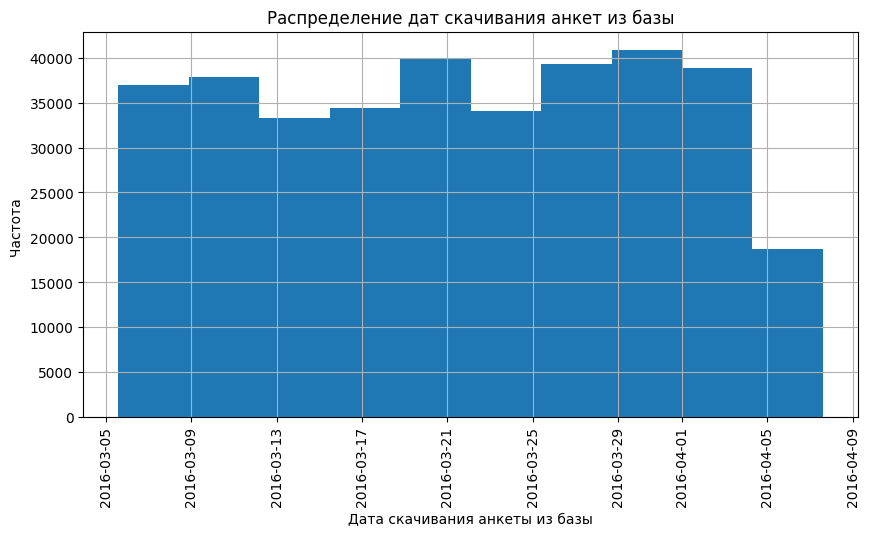

In [40]:
autos['date_crawled'].hist(xrot=90, figsize=(10, 5))
plt.xlabel('Дата скачивания анкеты из базы')
plt.ylabel('Частота ')
plt.title('Распределение дат скачивания анкет из базы');

In [41]:
display(autos['date_crawled'].min())
autos['date_crawled'].max()

Timestamp('2016-03-05 14:06:22')

Timestamp('2016-04-07 14:36:58')

Таким образом, имеем данные с 05.03.2016 по 07.04.2016, то есть примерно за месяц.

### ```price```

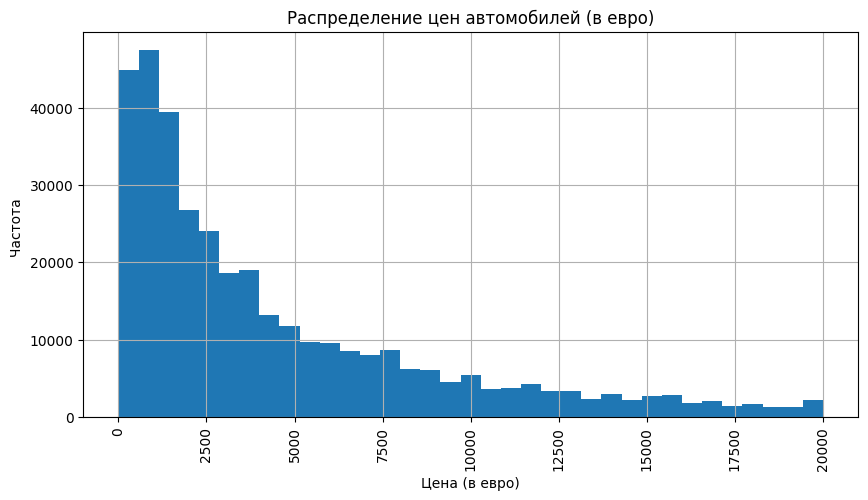

In [42]:
autos['price'].hist(bins=35, xrot=90, figsize=(10, 5))
plt.xlabel('Цена (в евро)')
plt.ylabel('Частота ')
plt.title('Распределение цен автомобилей (в евро)');

<AxesSubplot:>

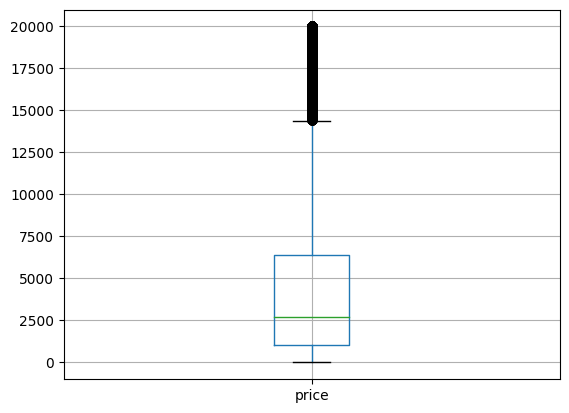

In [43]:
autos.boxplot('price')

Видим, что в целом распределение цен похоже на распределение Пуассона. Однако, возможно, есть автомобили с нулевой ценой. По диаграмме размаха видим также, что автомобили дороже 15 тысяч евро считаются за выбросы. Но в целом даже поддержанные автомобили могут стоить достаточно дорого, например раритетные и редкие. Медианным значением является цена в 2500 евро, что достаточно мало. Если брать среднегодовой курс евро к рублю за 2016 год, это значение в районе 185 тысяч рублей. То есть большинство поддержанных машин продаются достаточно дешево. Посмотрим есть ли автомобили с нулевой ценой.

In [44]:
autos.query('price == 0').shape[0]

10771

Видим, что есть 10 771 строка с автомобилями с нулевой ценой. Теперь проверим уникальные значения в столцбе ```price```.

In [45]:
autos['price'].sort_values().unique()[:100]

array([  0,   1,   2,   3,   4,   5,   7,   8,   9,  10,  11,  12,  13,
        14,  15,  16,  17,  18,  19,  20,  21,  24,  25,  26,  27,  29,
        30,  32,  33,  35,  38,  39,  40,  45,  47,  49,  50,  55,  58,
        59,  60,  65,  66,  69,  70,  74,  75,  77,  79,  80,  85,  88,
        89,  90,  95,  98,  99, 100, 101, 105, 106, 108, 110, 111, 112,
       115, 117, 119, 120, 121, 122, 123, 125, 126, 127, 128, 129, 130,
       132, 133, 135, 139, 140, 142, 145, 149, 150, 155, 156, 157, 158,
       159, 160, 162, 165, 166, 169, 170, 173, 175], dtype=int64)

Видим, что есть автомобили с подозрительно низкими ценами. Согласно "Обзору ИИ" от Google цены на поддержанные машины в 2016 году начинались от несколько сотен евро. Запрос был сделан для Германии в 2016 году, так как для Мазды и Вольво, японского и швецкого брендов, модели указаны с использованием немецкого слова "reihe" - серия. Есть и другие немецко говорящие страны, но в целом уровень жизни во всех высокий, а от этого зависят и цены. Оставим данные только по тем автомобилям, цена которых не менее 200 евро.

In [46]:
# получим долю данных, которые предполагаются к удалению
autos.query('price < 200').shape[0] / autos.shape[0]

0.049285875578638366

Таким образом, удалению подвергнутся 4% исходных обработанных данных.

In [47]:
autos = autos.query('price >= 200')
autos.shape[0]

336819

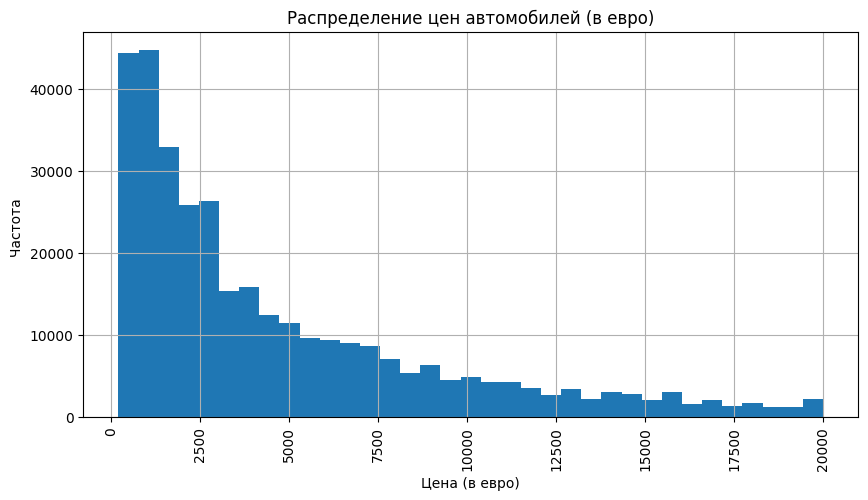

In [48]:
autos['price'].hist(bins=35, xrot=90, figsize=(10, 5))
plt.xlabel('Цена (в евро)')
plt.ylabel('Частота ')
plt.title('Распределение цен автомобилей (в евро)');

<AxesSubplot:>

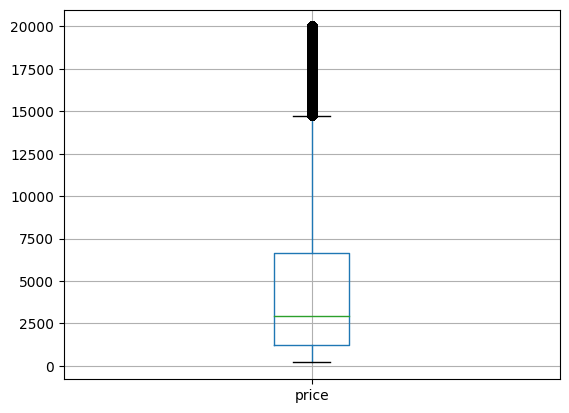

In [49]:
autos.boxplot('price')

Оставили анкеты с ценами не менее 200 евро. Опять же, видим выбросы для цен, значение которых выше 15000 евро. Но по диаграмме видим, что цены убывают "плавно", поэтому оставим эти значения.

### ```vehicle_type```

In [50]:
# функция для графика пирога для категориальных параметров
def categ_analysis(df, column):
    display(df[column].value_counts().to_frame())
    df[column].value_counts().plot.pie(autopct='%1.1f%%')

,vehicle_type
sedan,88545
small,75607
wagon,63112
unknown_vehicle_type,31380
bus,28210
convertible,19774
coupe,15436
suv,11750
other,3005


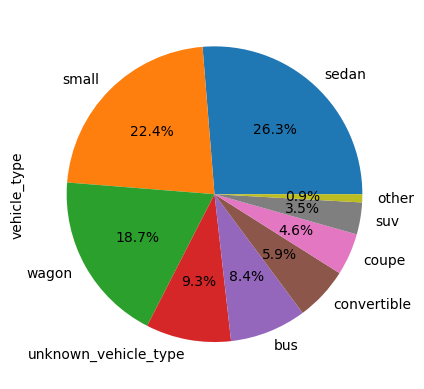

In [51]:
categ_analysis(autos, 'vehicle_type')

Видим, что около половины автомобиль имею типы кузова ```sedan``` и ```small```. На третьем месте ```wagon```. Также для около 10% автомобилей не указан тип кузова. Пятое место, опережая купе и савы, занимают автобусы, что достаточно неожиданно. Тем не менее, в задаче не указан источник данных, поэтому делать выводы о возможных причинах этого затруднительно.

Пропущенные значения в типе кузова не будем заменять на значения по типу моды. В задании отсутствует информация будут ли обязательны для заполнения какие-либо конкретные поля, для клиентов, которые хотели бы узнать рыночную стоимость своего автомобиля. В случае, если тип кузова будет обязателен для заполнения, стоило бы заполнить пропущенные значения. Для удобства пользователей, маловероятно подобное ограничение для типа кузова, так как иногда это может не иметь смысла, если модель выпускается в одном типе кузова (можно бы было заполнить в таком случае тип кузова для указанных моделей, но для этого нужна информация о моделях и возможных типах кузова, а также информация о том, что такую же информацию будут вести и обновлять сервис "Не бит, не крашен"). Также, может быть, пользователь захочет оценить автомобиль, не вдаваясь в подробности. Скорее всего, разница для одной и той же модели, но с разными кузовами, не будет столь существенна, чтобы принимать ее во внимание при быстрой оценке, так как скорее всего пользователей будет интересовать именно быстрая оценка, в связи с тем, что детальная оценка возможна только при изучении автомобиля профессионалами.

### ```registration_year```

In [52]:
# посмотрим на самые ранние года
autos['registration_year'].value_counts().sort_index(ascending=True).head(50)

1000     20
1001      1
1039      1
1111      1
1234      3
1300      1
1400      1
1500      2
1600      2
1602      1
1800      4
1910     28
1923      2
1925      1
1927      1
1928      2
1929      6
1930      2
1931      1
1932      3
1933      2
1934      2
1935      3
1936      3
1937     10
1938      8
1940      2
1941      2
1942      2
1943      4
1944      2
1945      4
1946      1
1947      2
1948      2
1949      1
1950     13
1951     10
1952      8
1953     14
1954      9
1955     13
1956     25
1957     13
1958     20
1959     29
1960    114
1961     35
1962     39
1963     55
Name: registration_year, dtype: int64

Видим, что года до 1910 явно аномальные и не отражают действительности. Посмотрим на анкеты с годом регистрации в 1910 году.

In [53]:
autos.query('registration_year == 1910')

,date_crawled,price,vehicle_type,registration_year,gearbox,power,model,kilometer,registration_month,fuel_type,brand,repaired,date_created,postal_code,last_seen
15,2016-03-11 21:39:15,450,small,1910,unknown_gearbox,0,ka,5000,0,gasoline,ford,unknown_repaired,2016-03-11,24148,2016-03-19 08:46:47
10183,2016-03-27 13:59:08,1250,unknown_vehicle_type,1910,unknown_gearbox,0,other,5000,0,unknown_fuel_type,audi,unknown_repaired,2016-03-27,18445,2016-04-07 10:45:31
23750,2016-03-16 19:58:34,3900,wagon,1910,manual,90,passat,150000,0,gasoline,volkswagen,unknown_repaired,2016-03-16,88662,2016-04-07 05:45:53
35943,2016-03-19 10:57:31,200,other,1910,unknown_gearbox,0,caddy,150000,0,gasoline,volkswagen,unknown_repaired,2016-03-19,35096,2016-03-20 18:10:33
48958,2016-03-09 07:36:58,600,small,1910,manual,0,agila,5000,0,unknown_fuel_type,opel,yes,2016-03-09,61279,2016-04-06 05:46:18
57063,2016-03-30 07:36:23,1000,unknown_vehicle_type,1910,unknown_gearbox,0,unknown_model,150000,0,unknown_fuel_type,sonstige_autos,unknown_repaired,2016-03-30,63303,2016-04-06 16:45:19
62803,2016-03-07 22:58:46,3400,small,1910,manual,90,beetle,90000,4,unknown_fuel_type,volkswagen,no,2016-03-07,34308,2016-03-12 08:16:51
74814,2016-03-21 12:52:05,400,unknown_vehicle_type,1910,unknown_gearbox,60,golf,150000,0,gasoline,volkswagen,unknown_repaired,2016-03-21,29462,2016-03-25 09:17:54
78374,2016-04-04 20:39:52,250,other,1910,unknown_gearbox,0,unknown_model,5000,1,unknown_fuel_type,audi,unknown_repaired,2016-04-04,99947,2016-04-06 22:46:27
82829,2016-03-14 08:51:18,500,unknown_vehicle_type,1910,unknown_gearbox,0,corsa,150000,0,unknown_fuel_type,opel,unknown_repaired,2016-03-14,52393,2016-04-03 07:53:55


Видим, что в списке есть автомобили, производство которых началось позже 1910 года. Далее года регистрации уже "не отстают" так сильно друг от друга, а их подробное изучение потребует времени на ручной поиск дат начала их производства. Также в анкетах присутствуют модели автомобилей, как например Fiat 500, для которых нельзя однозначно интерпретировать какая именно модель имеется ввиду. Некоторые модели перевыпускаются.

Заменим данные на средние значения по группам из бренда и модели или только модели, если нет бренда, для анкет до 1923 года и начиная с 2016. Но сначала проверим есть ли среди данных ранее 1923 и позднее 2016 годов автомобилей с неуказанной моделью.

In [54]:
autos.query('model == "unknown_model" and registration_year < 1923 and registration_year > 2016').shape[0]

0

Так как таких анкет нет, сделаем замену по группам из бренда и модели.

In [55]:
brand_model_grouped = autos.groupby(['brand', 'model'])
brand_model_grouped

Для сравнения выведем гистограмму периода 1923 и 2016 года.

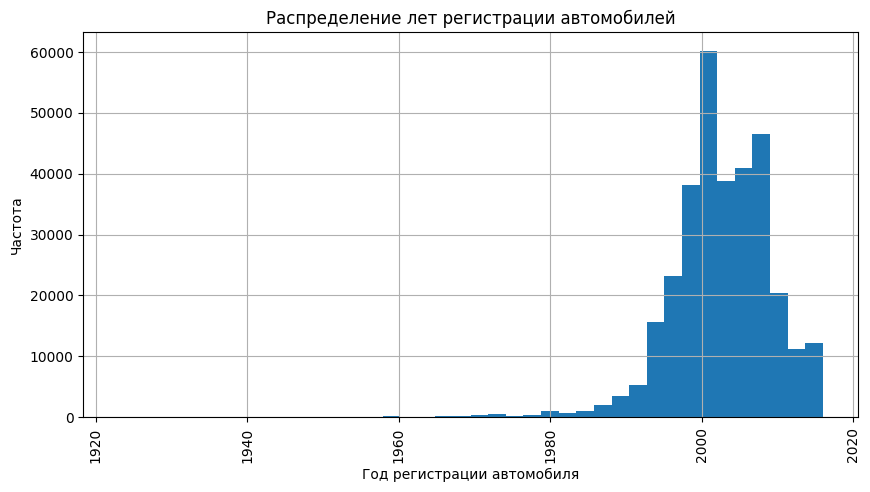

In [56]:
autos.query('registration_year >= 1923 and registration_year <= 2016')['registration_year'].hist(bins=40, xrot=90, figsize=(10, 5))
plt.xlabel('Год регистрации автомобиля')
plt.ylabel('Частота')
plt.title('Распределение лет регистрации автомобилей');

In [57]:
# заменяем значения
autos['registration_year'] = brand_model_grouped['registration_year'] \
                                .apply(lambda x: x.where((x >= 1923) & (x <= 2016), x[(x >= 1923) & (x <= 2016)].mean().round()))

In [58]:
autos.query('registration_year < 1923 and registration_year > 2016').shape[0]

0

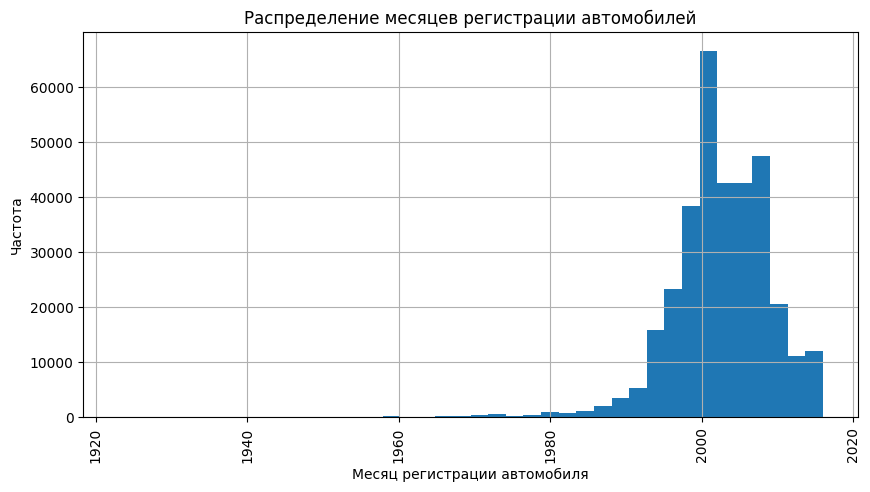

In [59]:
autos['registration_year'].hist(bins=40, xrot=90, figsize=(10, 5))
plt.xlabel('Месяц регистрации автомобиля')
plt.ylabel('Частота')
plt.title('Распределение месяцев регистрации автомобилей');

Видим, что после изменений сильных изменений не произошло в части вида гистограммы в период с 1923 по 2016 года, пик в районе 2000 года можно было наблюдать и до изменений. Большинство автомобилей зарегестрировано, начиная примерно с 1990 года. Мы не знаем, что именно означает год регистрации. Вполне может быть, что автомобиль произведен в 1948 году в Великобритании, ввезен в Германию в 2016 и тогда же там зарегистрирован. Поэтому необходимо просмотреть все модели с подозрительной регистрацией и искать год производства. Таких случаев много в масштабе ручной работы и мало в масштабе всех данных, поэтому не будем этого делать.

### ```registration_month```

In [60]:
autos['registration_month'].unique()

array([ 0,  5,  8,  6,  7, 10, 12, 11,  2,  3,  1,  4,  9], dtype=int64)

Видим среди месяцев регистрации значение 0.

In [61]:
autos.query('registration_month == 0').shape[0]

30135

Посмотрим на текущее распределение средних значений месяца регистрации по годам.

,registration_month
6.0,46
5.0,22
1.0,9
7.0,8
4.0,3
3.0,1
2.0,1
12.0,1


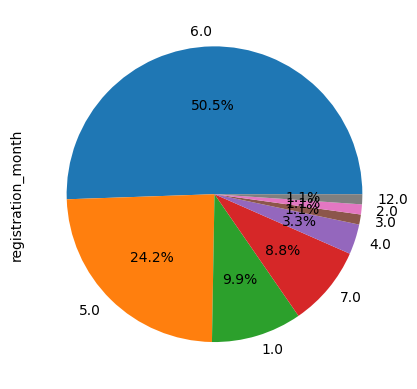

In [62]:
year_mean = autos.query('registration_month != 0').groupby('registration_year')['registration_month'].mean().round()
year_mean = year_mean.reset_index()
categ_analysis(year_mean, 'registration_month')

Видим, что для большей части лет, среднее значение месяца регистрации это 6, то есть май. Видимо, наиболее часто люди регистрируют и, скорее всего, покупают автомобили перед летним сезоном.

Заменим нулевые месяцы регистрации на средние значения месяца регистрации, группируя по году.

In [63]:
brand_model_grouped = autos.groupby(['registration_year'])

In [64]:
autos['registration_month'] = brand_model_grouped['registration_month'] \
    .apply(lambda x: x.where(x != 0, x[x != 0].mean().round()) if (x != 0).any() else x)
autos.query('registration_month == 0').shape[0]

0

,registration_month
6.0,46
5.0,22
1.0,9
7.0,8
4.0,3
3.0,1
2.0,1
12.0,1


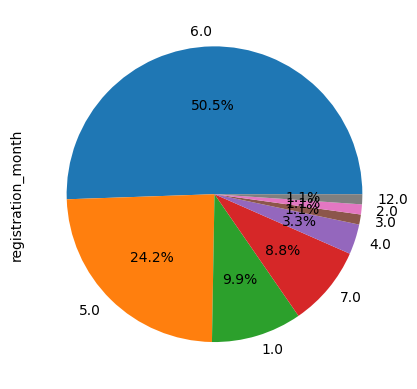

In [65]:
year_mean = autos.groupby('registration_year')['registration_month'].mean().round()
year_mean = year_mean.reset_index()
categ_analysis(year_mean, 'registration_month')

Видим, что в целом картина не изменилась после внесения изменений. Май остался наиболее популярным месяцем регистрации. Остальные месяцы также распределены аналогично.

### ```gearbox```

In [66]:
autos['gearbox'].unique()

array(['manual', 'auto', 'unknown_gearbox'], dtype=object)

,gearbox
manual,256789
auto,64476
unknown_gearbox,15554


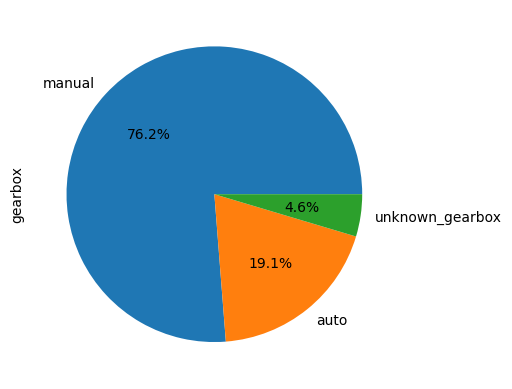

In [67]:
categ_analysis(autos, 'gearbox')

Как ранее отмечалось, заменять неизвестные коробки передач по группам брендам-моделям не имеет смысла, так как одна и та же модель может производится в двух вариантах. Ожидаемо, наиболее популярной является ручная коробка передач.

### ```power```

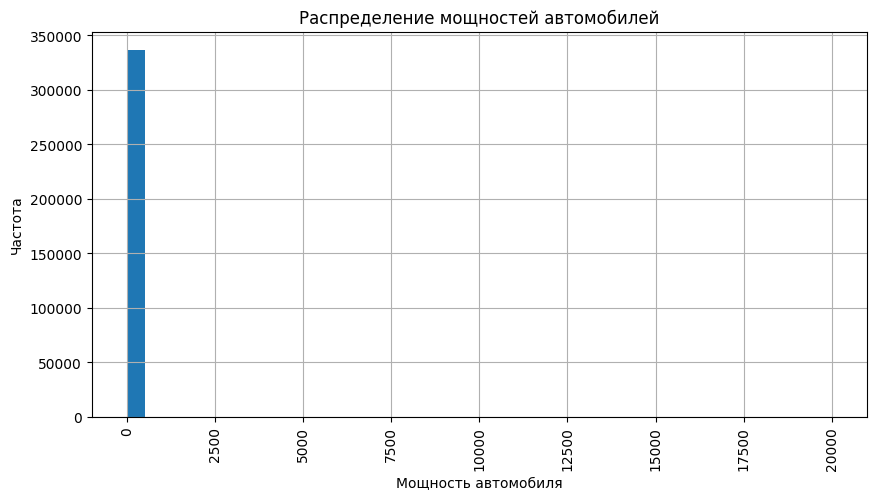

In [68]:
autos['power'].hist(bins=40, xrot=90, figsize=(10, 5))
plt.xlabel('Мощность автомобиля')
plt.ylabel('Частота')
plt.title('Распределение мощностей автомобилей');

<AxesSubplot:>

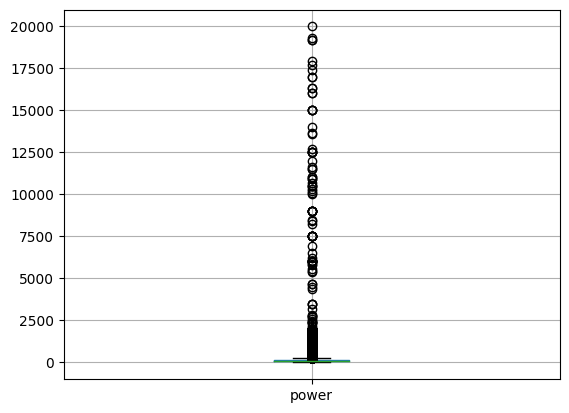

In [69]:
autos.boxplot('power')

Видим большое количество значений, которые посчитались за выбросы. Bugatti Chiron, спортивный автомобиль, имеет мощность в 1500 лошадинных сил. Таким образом, в датафрейме видим явно аномальные значения.

In [70]:
autos.query('power > 1500').shape[0]

183

Видим, что для 183 автомобилей мощность указана больше чем у Bugatti.

Посмотрим есть ли автомобили, для которых указана нулевая мощность.

In [71]:
autos.query('power == 0').shape[0]

33631

In [72]:
sorted(autos['power'].unique())

[0,
 1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 21,
 22,
 23,
 24,
 25,
 26,
 27,
 28,
 29,
 30,
 31,
 32,
 33,
 34,
 35,
 36,
 37,
 38,
 39,
 40,
 41,
 42,
 43,
 44,
 45,
 46,
 47,
 48,
 49,
 50,
 51,
 52,
 53,
 54,
 55,
 56,
 57,
 58,
 59,
 60,
 61,
 62,
 63,
 64,
 65,
 66,
 67,
 68,
 69,
 70,
 71,
 72,
 73,
 74,
 75,
 76,
 77,
 78,
 79,
 80,
 81,
 82,
 83,
 84,
 85,
 86,
 87,
 88,
 89,
 90,
 91,
 92,
 93,
 94,
 95,
 96,
 97,
 98,
 99,
 100,
 101,
 102,
 103,
 104,
 105,
 106,
 107,
 108,
 109,
 110,
 111,
 112,
 113,
 114,
 115,
 116,
 117,
 118,
 119,
 120,
 121,
 122,
 123,
 124,
 125,
 126,
 127,
 128,
 129,
 130,
 131,
 132,
 133,
 134,
 135,
 136,
 137,
 138,
 139,
 140,
 141,
 142,
 143,
 144,
 145,
 146,
 147,
 148,
 149,
 150,
 151,
 152,
 153,
 154,
 155,
 156,
 157,
 158,
 159,
 160,
 161,
 162,
 163,
 164,
 165,
 166,
 167,
 168,
 169,
 170,
 171,
 172,
 173,
 174,
 175,
 176,
 177,
 178,
 179,
 180,
 181,
 182,
 183,
 184,


Значения мощностей автомобиля имеют значения, начиная с 0 и заканчивая 20000. Сгруппируем данные по бренду и модели, и заменим значения, которые будут определены как выбросы внутри группы на медианное.

In [73]:
brand_model_grouped = autos.groupby(['brand', 'model'])

In [74]:
autos['power'] = brand_model_grouped['power'].apply(lambda x:
       x.where(((x <= x.quantile(0.75) + 1.5 * (x.quantile(0.75) - x.quantile(0.25))) & 
                                     (x >= x.quantile(0.25) - 1.5 * (x.quantile(0.75) - x.quantile(0.25)))), x.median())
                                                   if len(x) >= 10 else x)

In [75]:
autos.query('power < 50').shape[0]

12257

Видим, что осталось 12 тысяч записей с мощностью менее 50 лошадинных сил. Посмотрим на диаграмму размаха.

<AxesSubplot:>

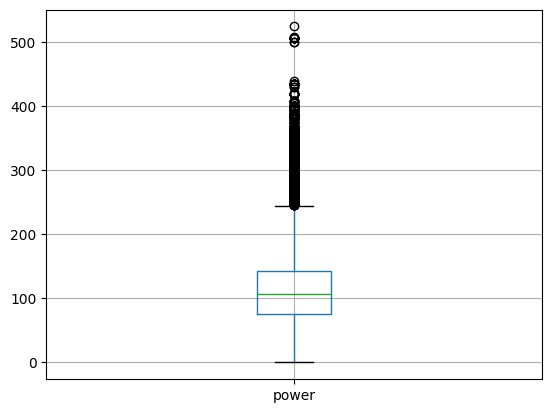

In [76]:
autos.boxplot('power')

Видим, что теперь аномальные значенич не превышают 550 лошадинных сил. Однако еще остались нулевые мощности.

In [77]:
autos.query('power < 50')['power'].value_counts()

0.0     7327
45.0    2543
41.0     434
44.0     305
26.0     255
40.0     245
34.0     170
39.0     114
5.0       89
48.0      79
43.0      62
46.0      50
42.0      46
33.0      45
37.0      39
27.0      35
23.0      33
47.0      31
30.0      30
29.0      29
4.0       25
24.0      25
11.0      22
49.0      20
38.0      20
20.0      18
14.0      16
25.0      15
15.0      14
12.0      12
35.0      10
3.0        8
18.0       8
7.0        7
6.0        7
17.0       6
31.0       6
1.0        6
2.0        6
19.0       6
13.0       5
10.0       5
16.0       5
9.0        5
36.0       4
28.0       4
22.0       4
21.0       3
8.0        3
32.0       1
Name: power, dtype: int64

Теперь заменим конкретно нулевые значения на медианы по группам бренда и модели.

In [78]:
brand_model_grouped = autos.groupby(['brand', 'model'])
autos['power'] = brand_model_grouped['power'].apply(lambda x:
       x.where((x != 0), x[x != 0].median()) if len(x) >= 10 else x)

In [79]:
autos.query('power == 0')['model'].unique()

array(['serie_2', 'i3', 'kalina', 'serie_1', 'elefantino'], dtype=object)

Нулевые значения все еще остались для некоторых моделей. Рассмотрим их отдельно.

<AxesSubplot:>

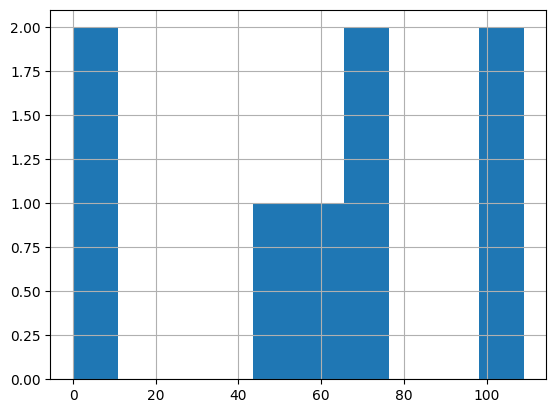

In [80]:
autos.query('model == "serie_2"')['power'].hist()

In [81]:
autos.query('model == "serie_2" and power != 0')['power'].median()

69.5

Заменим нулевые значения на медианные, рассчитанные без нулевых значений.

In [82]:
autos.loc[(autos['model'] == 'serie_2') & (autos['power'] == 0), 'power'] = \
                    autos.query('model == "serie_2" and power != 0')['power'].median()

<AxesSubplot:>

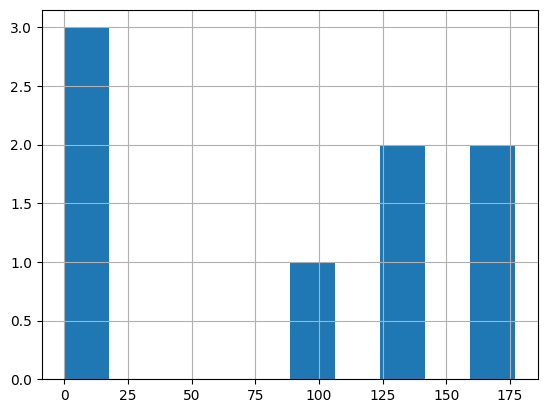

In [83]:
autos.query('model == "i3"')['power'].hist()

In [84]:
autos.loc[(autos['model'] == 'i3') & (autos['power'] == 0), 'power'] = \
                    autos.query('model == "i3" and power != 0')['power'].median()

<AxesSubplot:>

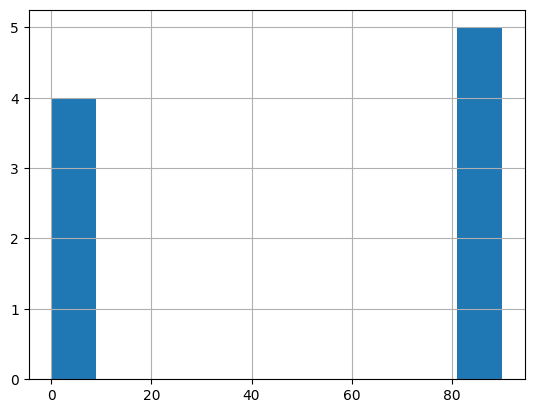

In [85]:
autos.query('model == "kalina"')['power'].hist()

In [86]:
autos.loc[(autos['model'] == 'kalina') & (autos['power'] == 0), 'power'] = \
                    autos.query('model == "kalina" and power != 0')['power'].median()

<AxesSubplot:>

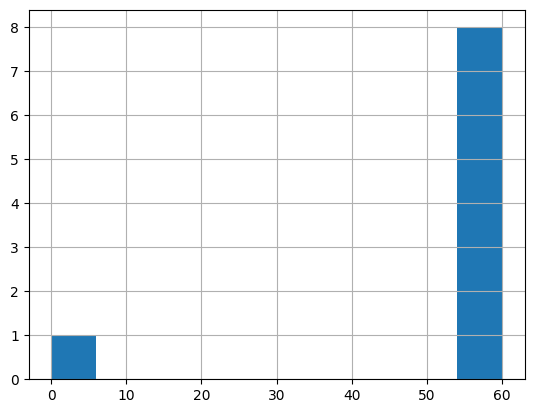

In [87]:
autos.query('model == "elefantino"')['power'].hist()

In [88]:
autos.loc[(autos['model'] == 'elefantino') & (autos['power'] == 0), 'power'] = \
                    autos.query('model == "elefantino" and power != 0')['power'].median()

<AxesSubplot:>

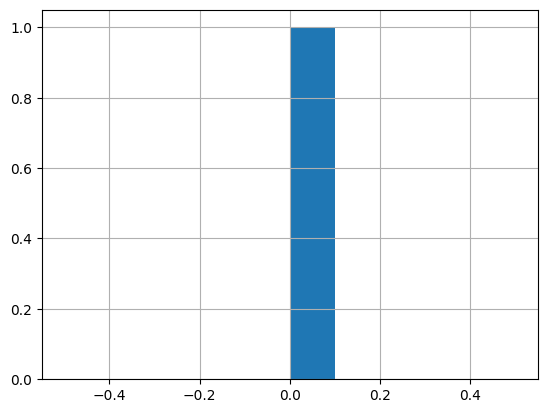

In [89]:
autos.query('model == "serie_1"')['power'].hist()

Для Land Rover Serie 1 есть только одна запись. Заменим значение мощности на то, которое указано в сети интернет - 50 лошадинных сил.

In [90]:
autos.loc[autos['model'] == 'serie_1', 'power'] = 50

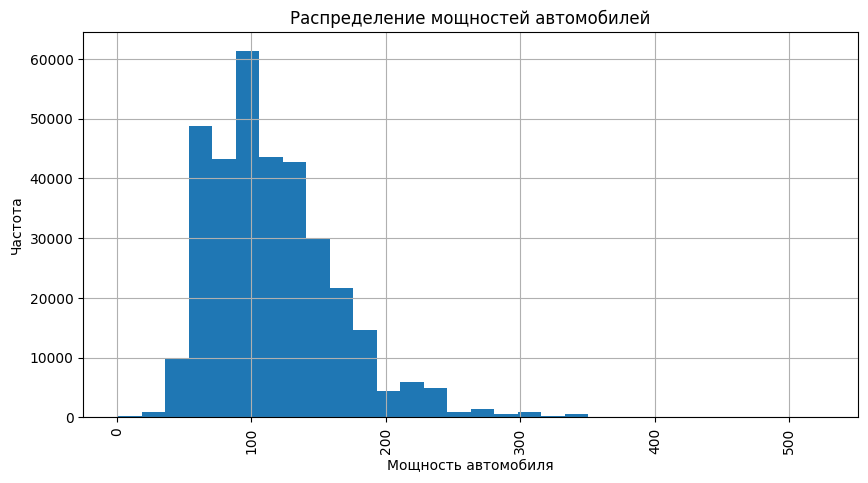

In [91]:
autos['power'].hist(bins=30, xrot=90, figsize=(10, 5))
plt.xlabel('Мощность автомобиля')
plt.ylabel('Частота')
plt.title('Распределение мощностей автомобилей');

Видим, что наибольшее количество автомобилей имеет мощность в диапазоне примерно от 50 до 200 лошадинных сил. Также есть значения мощности в районе 500 лошадинных сил. Но в целом такая ситуация вероятна, так как для автомобилей возможно увеличение мощности.

### ```brand```

,brand
volkswagen,73031
opel,37291
bmw,35447
mercedes_benz,31153
audi,28334
ford,23525
renault,16812
peugeot,10589
fiat,9030
seat,6587


<AxesSubplot:ylabel='brand'>

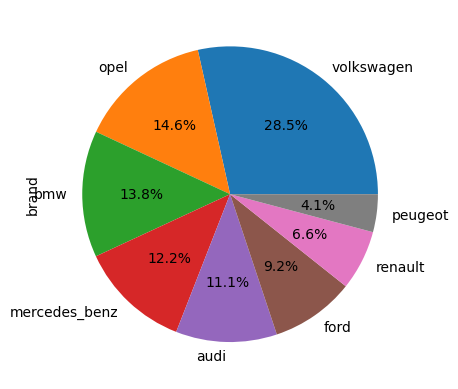

In [92]:
display(autos['brand'].value_counts().to_frame())
autos['brand'].value_counts()[:8].plot.pie(autopct='%1.1f%%')

Видим, что в топ-5 входят только немецкие бренды. Далее идет амерканский Ford и французские Renault и Peugeot. Наименее популярным брендом является Lada. Также видим, что не так много Porsche, несмотря на то, что это известный немецкий бренд. Однако, это дорогие машины.

### ```model```

,brand_model
volkswagen_golf,27749
bmw_3er,19005
volkswagen_polo,12118
opel_corsa,11541
opel_astra,10234
volkswagen_passat,9765
audi_a4,9581
mercedes_benz_c_klasse,8154
bmw_5er,7604
mercedes_benz_e_klasse,6589


<AxesSubplot:ylabel='brand_model'>

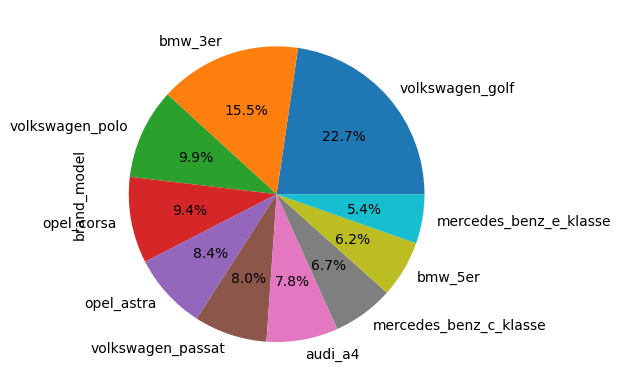

In [93]:
autos.loc[:, 'brand_model'] = autos['brand'] + '_' + autos['model']
display(autos['brand_model'].value_counts()[:10].to_frame())
autos['brand_model'].value_counts()[:10].plot.pie(autopct='%1.1f%%')

Если немецкие бренды занимали топ-5, то модели немецких брендов занимают как минимум топ-10. Замыкают топ-10 3 модели бизнес-класса. То есть они достаточно популярны среди поддержанных автомобилей.

### ```kilometer```

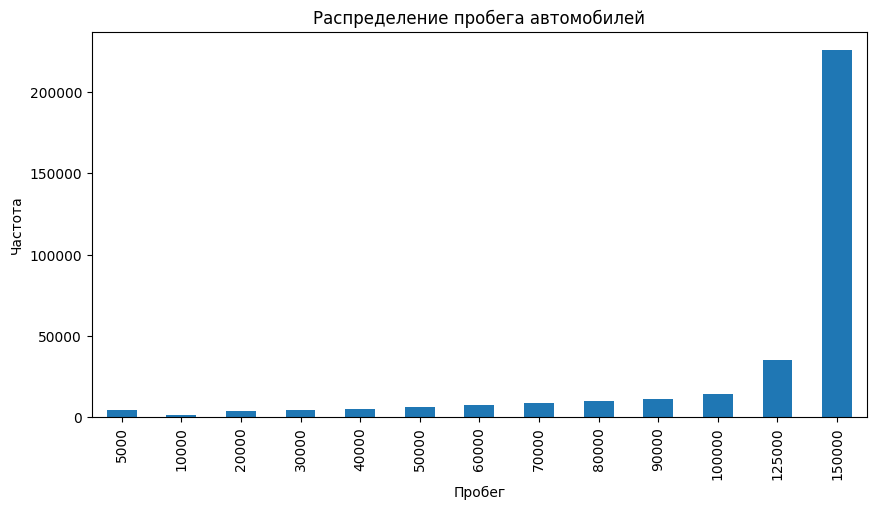

In [94]:
autos.groupby('kilometer')['date_crawled'].count().plot.bar(figsize=(10, 5))
plt.xlabel('Пробег')
plt.ylabel('Частота')
plt.title('Распределение пробега автомобилей');

Большинство автомобилей имеет пробег в 150 000 километров, что логично для поддержанных автомобилей.

### ```fuel_type```

,fuel_type
gasoline,303459
unknown_fuel_type,27212
lpg,5143
cng,548
hybrid,225
other,147
electric,85


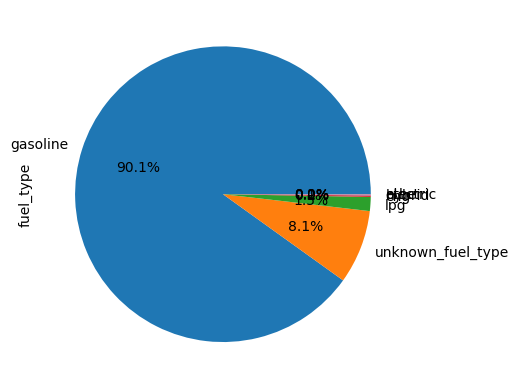

In [95]:
categ_analysis(autos, 'fuel_type')

Бензин является абсолютным лидером по количеству автомобилей, использующих его. На втором месте находятся неизвестные виды топлива. Остальные  виды топлива занимают очень малую часть рынка.

### ```repaired```

,repaired
no,242382
unknown_repaired,62440
yes,31997


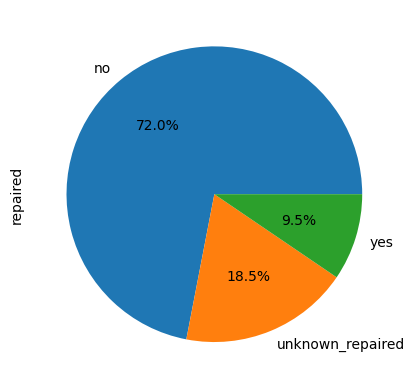

In [96]:
categ_analysis(autos, 'repaired')

Большинство машин (72 %) не ремонтировались. Для 20% автомобилей нет информации о ремонте. Точно ремонтировались 9.5% автомобилей. Таким образом, достаточно существенное количество владельцев решили не указывать ремонтировался ли их автомобиль. Что, скорее всего, связано с тем, что это может снизить его цену.

### ```date_created```

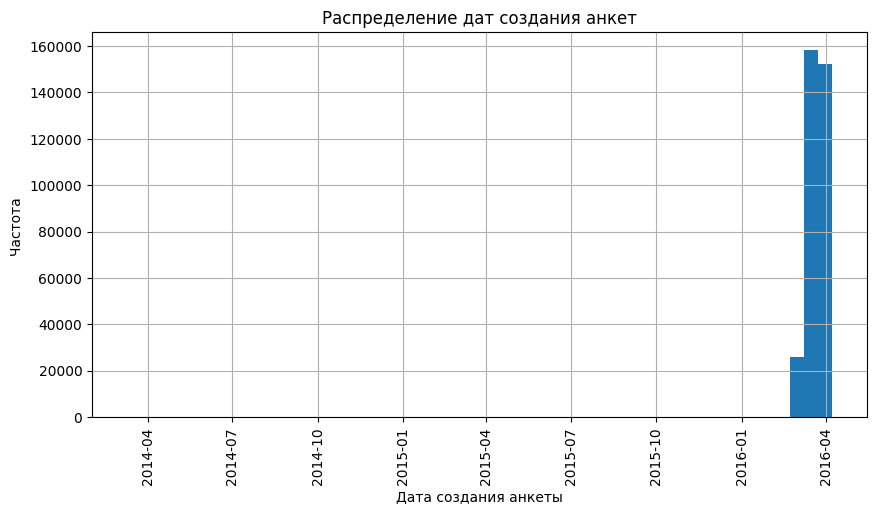

In [97]:
autos['date_created'].hist(bins=50, xrot=90, figsize=(10, 5))
plt.xlabel('Дата создания анкеты')
plt.ylabel('Частота ')
plt.title('Распределение дат создания анкет');

In [98]:
autos['date_created'].value_counts()[:40]

2016-04-03    13141
2016-04-04    12685
2016-03-12    12276
2016-03-20    12258
2016-03-21    12033
2016-03-14    11857
2016-03-28    11854
2016-04-02    11801
2016-03-07    11601
2016-03-19    11556
2016-03-09    11512
2016-03-29    11449
2016-04-01    11404
2016-03-08    11261
2016-03-30    11241
2016-03-15    11189
2016-03-11    11063
2016-03-25    11051
2016-03-10    11002
2016-03-22    10860
2016-03-26    10850
2016-03-23    10772
2016-03-31    10731
2016-03-17    10561
2016-03-16    10280
2016-03-27    10053
2016-03-24    10011
2016-03-05     7782
2016-03-13     5749
2016-03-06     5238
2016-03-18     4731
2016-04-05     3880
2016-04-06     1035
2016-03-04      586
2016-04-07      513
2016-03-03      382
2016-03-01       50
2016-02-28       49
2016-02-29       45
2016-03-02       35
Name: date_created, dtype: int64

Большинство анкет было создано в марте 2016 года. Прямо перед началом скачивания анкет из базы. Данные об источники анкет отсутствуют, поэтому делать какой-либо вывод не представляется возможным.

### ```last_seen```

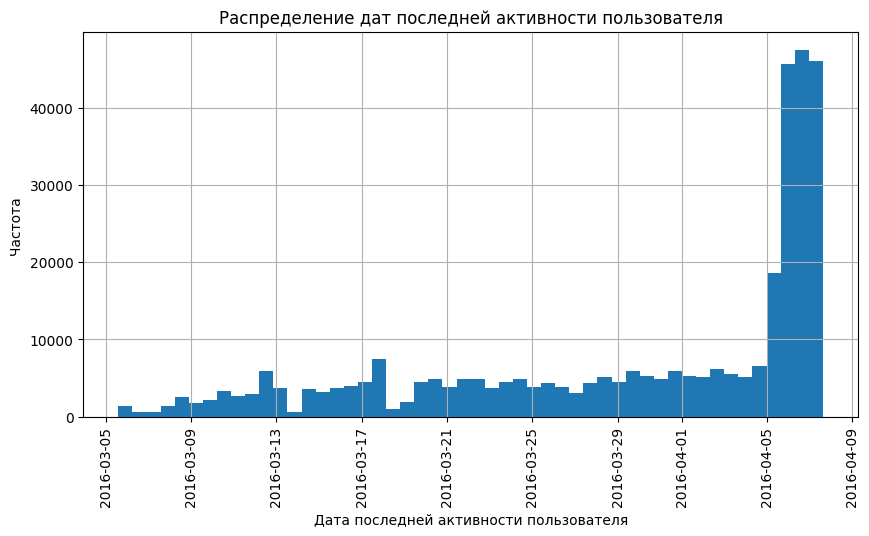

In [99]:
autos['last_seen'].hist(bins=50, xrot=90, figsize=(10, 5))
plt.xlabel('Дата последней активности пользователя')
plt.ylabel('Частота ')
plt.title('Распределение дат последней активности пользователя');

Все пользователи были активны в марте и апреле 2016 года и особенно в последние скачивания анкет.

### Корреляция

Удалим из датафрейма столбец ```postal_code```, так как он не представляет информационной значимости сам по себе. Для изучения его влияния необходима дополнительная информация.

In [100]:
autos = autos.drop('postal_code', axis=1)

In [101]:
autos.corr()

,price,registration_year,power,kilometer,registration_month
price,1.000000,0.437098,0.466127,-0.364695,0.013981
registration_year,0.437098,1.000000,0.103407,-0.228386,0.017142
power,0.466127,0.103407,1.000000,0.127352,0.026346
kilometer,-0.364695,-0.228386,0.127352,1.000000,0.010099
registration_month,0.013981,0.017142,0.026346,0.010099,1.000000


Видим, что на цену наиболее влияет год регистрации и мощность среди численных признаков.

Посмотрим на матрицу корреляции с категориальными признаками.

In [102]:
autos.columns

Index(['date_crawled', 'price', 'vehicle_type', 'registration_year', 'gearbox',
       'power', 'model', 'kilometer', 'registration_month', 'fuel_type',
       'brand', 'repaired', 'date_created', 'last_seen', 'brand_model'],
      dtype='object')

In [103]:
# создаём список с наименованиями непрерывных признаков
interval_cols = ['price', 'registration_year', 'power']

# считаем корреляции на тренировочной выборке
phik_overview = phik_matrix(autos.drop(['date_crawled', 'date_created', 'last_seen'], axis=1), interval_cols=interval_cols)

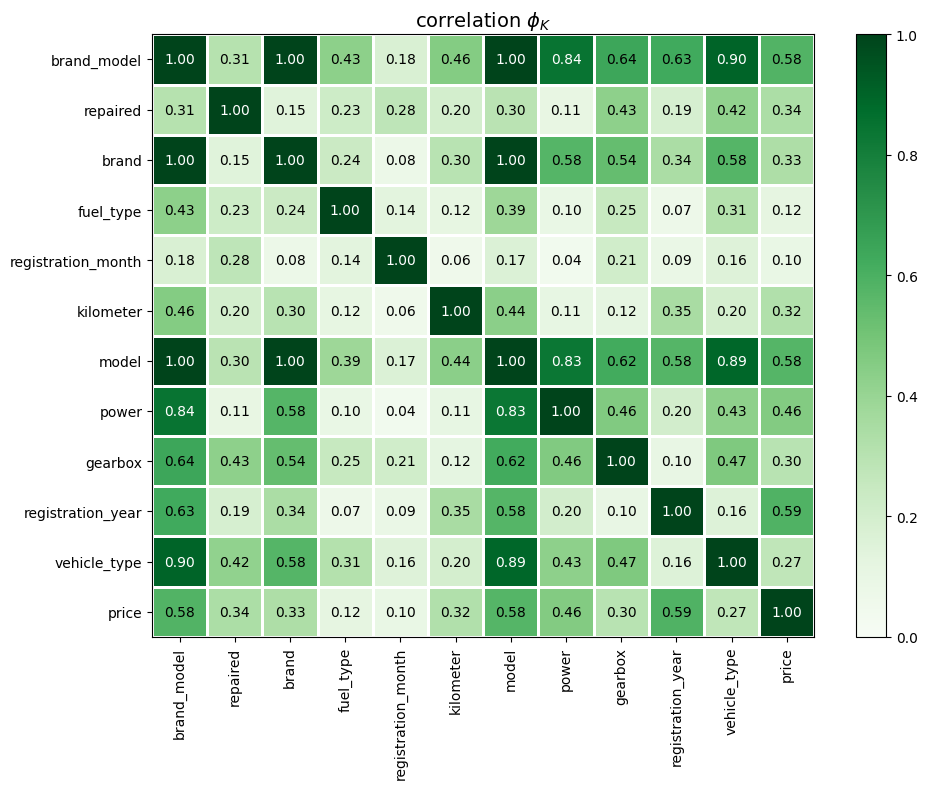

In [104]:
plot_correlation_matrix(
    phik_overview.values,
    x_labels=phik_overview.columns,
    y_labels=phik_overview.index,
    vmin=0, vmax=1, color_map='Greens',
    title=r'correlation $\phi_K$',
    figsize=(10, 8)
) 

Видим, что бренд и модель мультиколлинеарны. Коэфициент корреляция между ними равен единице. Поэтому далее оставим только созданный столбец, объединяющий бренд и модель.
Наименее сильное влияние на цену имеет месяц регистрации и тип топлива. Влияние остальных параметров варьируется от 0.27 до 0.59.

Также удалим из датафрейма столбцы с датами, так как модель машинного обучения должна будет предсказывать цены по параметрам автомобиля.

In [105]:
autos_b_m = autos.drop(['brand', 'model', 'date_crawled', 'date_created', 'last_seen'], axis=1)

In [106]:
autos_b_m.columns

Index(['price', 'vehicle_type', 'registration_year', 'gearbox', 'power',
       'kilometer', 'registration_month', 'fuel_type', 'repaired',
       'brand_model'],
      dtype='object')

После удаления неинформативных столбцов, проверим датафрейм на наличие дублей.

In [107]:
autos_b_m.columns

Index(['price', 'vehicle_type', 'registration_year', 'gearbox', 'power',
       'kilometer', 'registration_month', 'fuel_type', 'repaired',
       'brand_model'],
      dtype='object')

In [108]:
autos_b_m.duplicated().sum()

26686

Удалим дубликаты.

In [109]:
autos_b_m = autos_b_m.drop_duplicates()
autos_b_m.duplicated().sum()

0

Дубликаты удалены. Теперь рассмотрим описательную статистику.

In [110]:
autos_b_m.describe().T

,count,mean,std,min,25%,50%,75%,max
price,310133.0,4630.955745,4522.362953,200.0,1250.0,2950.0,6600.0,20000.0
registration_year,310133.0,2002.634654,6.736257,1923.0,1999.0,2003.0,2007.0,2016.0
power,310133.0,115.999386,48.389902,1.0,75.0,109.0,143.0,525.0
kilometer,310133.0,128335.681788,37298.625278,5000.0,125000.0,150000.0,150000.0,150000.0
registration_month,310133.0,6.366136,3.192685,1.0,4.0,6.0,9.0,12.0


Видим, что минимальное значение мощности равно 1. Ранее при разборе мощности увидели, что мощность в 50 лошадинных сил является приемлемой величиной, например, для достаточно старого автомобиля Land Rover Serie 1. Поэтому посмотрим минимальный год для автомобилей с лошадинными силами менее 50.

In [111]:
autos_b_m.query('power < 50')['registration_year'].min()

1927

Согласно ИИ-обзору от Google уже в 1927 году средняя мощность была в районе 40 лошадинных сил. Поэтому изменим мощности меньше на средние по бренду-модели.

In [112]:
autos_b_m['power'] = autos_b_m.groupby(['brand_model'])['power'].apply(lambda x:
       x.where((x >=40), x.median()))

In [113]:
autos_b_m.query('power < 40')['brand_model'].unique()

array(['trabant_unknown_model', 'trabant_601', 'trabant_other'],
      dtype=object)

Видим, что менее 40 лошадинных сил осталось только у бренда trabant. Согласно ИИ-обзору Гугл Trabant 601 имеет мощность в 26 лошадинных сил. Посмотрим какие значения мощности остались.

In [114]:
autos_b_m.query('power < 40')['power'].unique()

array([26.])

Таким образом, остались только допустимые значения мощности.

In [115]:
autos_b_m.describe().T

,count,mean,std,min,25%,50%,75%,max
price,310133.0,4630.955745,4522.362953,200.0,1250.0,2950.0,6600.0,20000.0
registration_year,310133.0,2002.634654,6.736257,1923.0,1999.0,2003.0,2007.0,2016.0
power,310133.0,116.181993,48.213083,26.0,75.0,109.0,143.0,525.0
kilometer,310133.0,128335.681788,37298.625278,5000.0,125000.0,150000.0,150000.0,150000.0
registration_month,310133.0,6.366136,3.192685,1.0,4.0,6.0,9.0,12.0


## Обучение моделей

In [116]:
autos_b_m.columns

Index(['price', 'vehicle_type', 'registration_year', 'gearbox', 'power',
       'kilometer', 'registration_month', 'fuel_type', 'repaired',
       'brand_model'],
      dtype='object')

In [117]:
# разделим данные на обучающую и тестовую выборки
features_train, features_test, target_train, target_test = train_test_split(
    autos_b_m.drop('price', axis=1), autos_b_m['price'], test_size=0.3, random_state=RANDOM_STATE)

In [118]:
# разделим данные на валидационнную и тестовую выборки
features_valid, features_test, target_valid, target_test = train_test_split(
    features_test, target_test, test_size=0.5, random_state=RANDOM_STATE)

Зададим столбцы для соответствующих преобразований.

In [119]:
ohe_columns = ['vehicle_type', 'gearbox', 'fuel_type', 'brand_model', 'repaired']

In [120]:
num_columns = ['registration_year', 'power']

In [121]:
ord_columns = ['kilometer', 'registration_month']

Зададим пайплайны для преобразований.

In [122]:
ohe_pipe = Pipeline(
    [('simpleImputer_ohe', SimpleImputer(missing_values=np.nan, strategy='most_frequent', add_indicator=True)),
     ('ohe', OneHotEncoder(drop='first', handle_unknown='ignore', sparse=False))
    ]
    )

In [123]:
ord_pipe = Pipeline(
    [('simpleImputer_before_ord', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
     ('ord',  OrdinalEncoder(
                categories=[
                    [5000, 10000, 20000, 30000, 40000, 50000, 60000, 70000,
                     80000, 90000, 100000, 125000, 150000],
                    [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]], 
                handle_unknown='use_encoded_value', unknown_value=np.nan
            )
        ),
     ('simpleImputer_after_ord', SimpleImputer(missing_values=np.nan, strategy='most_frequent'))
    ]
)

In [124]:
data_preprocessor = ColumnTransformer(
    [('ohe', ohe_pipe, ohe_columns),
     ('ord', ord_pipe, ord_columns),
     ('num', MinMaxScaler(), num_columns)
    ], 
    remainder='passthrough'
)

Функция, расчитывающая метрику RMSE.

In [125]:
def rmse(estimator, X, y):
    y_pred = estimator.predict(X)
    return np.sqrt(mean_squared_error(y, y_pred))

Преобразовываем выборки для обучения, валидации и тестирования.

In [126]:
features_train_transf = data_preprocessor.fit_transform(features_train)
features_valid_transf = data_preprocessor.transform(features_valid)
features_test_transf = data_preprocessor.transform(features_test)

Зададим модель DecisionTreeRegressor с гиперпараметрами по умолчанию.

In [127]:
dtr_model = DecisionTreeRegressor(random_state=RANDOM_STATE)

In [128]:
%%time
dtr_model.fit(features_train_transf, target_train)

CPU times: total: 7.81 s
Wall time: 7.96 s


DecisionTreeRegressor(random_state=12345)

In [129]:
%%time
dtr_model.predict(features_valid_transf)

CPU times: total: 31.2 ms
Wall time: 52.1 ms


array([ 2500.,  4750., 14950., ...,  4450.,   750., 10000.])

Модель обучается 12 секунд, предсказание происходит за 87 мсек.

Рассчитаем метрику RMSE на валидационных данных.

In [130]:
rmse(dtr_model, features_valid_transf, target_valid)

2280.437053721711

Таким образом, модель в среднем ошибается на 2280 евро.

Рассмотрим модель DecisionTreeRegressor с гиперпараметрам max_depth равным 15.

In [131]:
dtr_model_2 = DecisionTreeRegressor(random_state=RANDOM_STATE, max_depth = 15)

In [132]:
%%time
dtr_model_2.fit(features_train_transf, target_train)

CPU times: total: 6.33 s
Wall time: 6.45 s


DecisionTreeRegressor(max_depth=15, random_state=12345)

In [133]:
%%time
dtr_model_2.predict(features_valid_transf)

CPU times: total: 31.2 ms
Wall time: 39.2 ms


array([ 1838.58235194,  3421.78595627, 12861.06060606, ...,
        3734.43173759,   705.62046908, 10784.49479941])

In [134]:
rmse(dtr_model_2, features_valid_transf, target_valid)

2045.8007413164719

Модель обучается за 10 секунд, предсказывает за 63 мсек, метрика RMSE равна 2045 евро.

Обучим модель градиентного бустинга LightGBM.

In [135]:
# столбцы с категориальными признаками
cat_columns = ohe_columns + ord_columns
# столбцы признаков
feature_columns = cat_columns + num_columns

# преобразуем категориальными признаки в числа
features_train_gbm = features_train
features_train_gbm[cat_columns] = features_train_gbm[cat_columns].apply(lambda x: x.astype('category').cat.codes)
features_valid_gbm = features_valid
features_valid_gbm[cat_columns] = features_valid_gbm[cat_columns].apply(lambda x: x.astype('category').cat.codes)
features_test_gbm = features_test
features_test_gbm[cat_columns] = features_test_gbm[cat_columns].apply(lambda x: x.astype('category').cat.codes)

In [136]:
# создадим Dataset'ы LightGBM
train_dataset = lgb.Dataset(features_train_gbm, label=target_train, feature_name=feature_columns, \
                            categorical_feature=cat_columns)
valid_dataset = lgb.Dataset(features_valid_gbm, label=target_valid, feature_name=feature_columns, \
                            categorical_feature=cat_columns)
test_dataset = lgb.Dataset(features_test_gbm, label=target_test, feature_name=feature_columns, \
                            categorical_feature=cat_columns)

In [137]:
# параметры для обучения
params = {
 'task': 'train',
 'boosting_type': 'gbdt',
 'objective': 'regression',
 'metric': {'l2', 'l1', 'rmse'},
 'num_leaves': 31,
 'learning_rate': 0.05,
 'feature_fraction': 0.9,
 'bagging_fraction': 0.8,
 'bagging_freq': 5,
 'verbose': 0,
 # Укажите столбцы с категориальными признаками
 'categorical_feature': ['name:' + col for col in cat_columns]

}


In [138]:
%%time
model = lgb.train(params, train_dataset, num_boost_round=100, valid_sets=[valid_dataset])

D:\stude\anaconda3\envs\practicum\lib\site-packages\lightgbm\basic.py:2137: UserWarning: categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.
  _log_warning(
D:\stude\anaconda3\envs\practicum\lib\site-packages\lightgbm\basic.py:2159: UserWarning: categorical_feature in param dict is overridden.
  _log_warning(f"{cat_alias} in param dict is overridden.")


[LightGBM] [Warning] categorical_feature is set=name:vehicle_type,name:gearbox,name:fuel_type,name:brand_model,name:repaired,name:kilometer,name:registration_month, categorical_column=0,1,2,3,4,5,6 will be ignored. Current value: categorical_feature=name:vehicle_type,name:gearbox,name:fuel_type,name:brand_model,name:repaired,name:kilometer,name:registration_month
CPU times: total: 5.98 s
Wall time: 594 ms


Обучение происходило 1 мин 40 секунд.

In [139]:
valid_dataset = lgb.Dataset(features_valid_gbm, label=target_valid, feature_name=feature_columns, \
                            categorical_feature=cat_columns)

In [140]:
%%time
model.predict(valid_dataset.data)

CPU times: total: 547 ms
Wall time: 59.3 ms


array([ 2221.4880091 ,  3598.23792558, 14795.77780568, ...,
        3734.98547686,  1061.35483245,  9543.80915307])

Предсказание занимает 491 мсек.

In [141]:
rmse(model, valid_dataset.data, valid_dataset.label)

1938.5135172159364

Метрика RMSE для модели градиентного бустинга равна 1938 евро.

Были подготовлены и преобразованы выборки. Обучены три модели: две модели DecisionTreeRegressor с различными гиперпараметрами и модель градиентного бустинга библиотеки LightGBM.

## Анализ моделей

Критерии, которые важны заказчику:
- качество предсказания;
- время обучения модели;
- время предсказания модели.

Рассмотрим полученные данные по трем моделям.

DecisionTreeRegressor_1:
- RMSE = 2280
- время обучения - 12 сек
- время предсказания - 87 мсек;

DecisionTreeRegressor_2:
- RMSE = 2045
- время обучения - 10 сек
- время предсказания - 63 мсек;

LightGBM:
- RMSE = 1938
- время обучения - 1 мин 40 сек
- время предсказания - 491 мсек.

Видим, что вторая модель дерева решений лучше первой по всем критериям. LightGBM имеет более низкую метрику RMSE. Однако, время обучения и время предсказания в несколько раз хуже, чем у дерева решений, тогда как метрика RMSE лучше на примерно 80 евро. Поэтому в качестве модели для предсказания цены автомобиля заказчику предлагается использовать DecisionTreeRegressor(max_depth=15). Проверим качество модели на тестовой выборке.

In [142]:
rmse(dtr_model_2, features_test_transf, target_test)

2046.173488522102

На тестовой выборке модель также показала достаточно низкий результат в 2046 евро.

***Вывод:***
В результате работы были подготовлены данные, в том числе изменены наименования и типы столбцов, обработаны и заменены выбросы, удалены дубликаты. Далее данные были подготовлены и преобразованы для обучения моделей машинного обучения. Рассмотрены модели DecisionTreeRegressor() и DecisionTreeRegressor(max_depth). Обе модели показали достаточно хороший результат, но вторая моедель дерева решений была лучше по всем критериям, которые важны заказчику. Также была обучена модель градиентного бустинга LightGBM. Она показала лучший результат по метрике среднеквадратичного отклонения предсказанных значений от фактических (RMSE). Однако время ее обучения и время предсказания были в несколько раз больше времени обучения и предсказания второй модели дерева решений. По этой причине заказчику предлагается использовать вторую модель дерева решений с гиперпараметром максимальной глубины дерева, равной 15. На тестовой выборке эта модель также показала хороший результат в части значения метрики RMSE.